# Train Models using Feast historical data

* Collect historical features from Feast
* Rebuild the MNIST dataset from the features
* Train different models using the dataset
* Register models using Model Registry

In [52]:
!pip install --upgrade pip
!cat requirements.txt
!pip install -q -r requirements.txt
!pip install --no-deps --ignore-requires-python "https://github.com/opendatahub-io/ml-metadata/releases/download/v1.14.0%2Bremote.1/ml_metadata-1.14.0+remote.1-py3-none-any.whl" # need a Python 3.11 compatible version
!pip install --no-deps --ignore-requires-python "model-registry==0.1.2" # ignore dependencies because of the above override

feast==0.36.0
psycopg2>=2.9
onnx==1.14.1
onnxruntime
#tf2onnx
#typing-extensions==4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
codeflare-sdk 0.14.1 requires pydantic<2, but you have pydantic 2.7.0 which is incompatible.
codeflare-sdk 0.14.1 requires ray[data,default]==2.7.0, but you have ray 2.9.3 which is incompatible.
kfp 1.8.22 requires protobuf<4,>=3.13.0, but you have protobuf 4.23.3 which is incompatible.
kfp 1.8.22 requires pydantic<2,>=1.8.2, but you have pydantic 2.7.0 which is incompatible.
kfp-pipeline-spec 0.1.16 requires protobuf<4,>=3.13.0, but you have protobuf 4.23.3 which is incompatible.
kserve 0.12.0 requires fastapi<0.96.0,>=0.95.0, but you have fastapi 0.110.2 which is incompatible.
kserve 0.12.0 requires protobuf<4.0.0,>=3.19.0, but you have protobuf 4.23.3 which is incompatible.
ml-metadata 1.14.0+remote.1 requires attrs<22,>=20.

## Imports and constants

In [53]:
# import ast
import os
from datetime import datetime, timedelta

import boto3
import matplotlib.pyplot as plt
import numpy as np
import onnx
import onnxruntime as ort
import pprint
import pandas as pd
import tensorflow as tf
import tf2onnx
from feast import FeatureStore
from IPython.display import Markdown as md
from model_registry import ModelRegistry
from model_registry.types import ContextState
# Needs a new release of model-registry
# from model_registry.utils import s3_uri_from
from sklearn.metrics import accuracy_score
from sqlalchemy import create_engine, MetaData, Table, select, Column, Integer, DateTime
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

**Note**: update this value to match the actual data

In [54]:
%env REPO_PATH=mnist_demo/feature_repo/

env: REPO_PATH=mnist_demo/feature_repo/


In [55]:
os.environ['accesskey'] = 'minio'
os.environ['secretkey'] = 'minio123'
os.environ['AWS_S3_ENDPOINT'] = 'http://minio-service.feast.svc.cluster.local:9000'
os.environ['AWS_S3_BUCKET'] = 'feast'
os.environ['AWS_DEFAULT_REGION'] = 'default'

In [56]:
psqlHost = 'postgresql.feast.svc.cluster.local'
psqlPort = 5432
psqlUsername = 'feast'
psqlPassword = 'feast'
psqlDb = 'feast'
psqlSchema = 'feast'

mnistTableName = 'mnist_source'

## Reusable functions

In [57]:
def simpleNN():
    model = Sequential()

    model.add(Flatten(input_shape=(28,28)))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(10,activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

    model.summary()
    return model, 'simple_NN'

In [58]:
def convolutedNN():
    model = Sequential()

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=64, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model, 'convolutedNN'

In [59]:
def evaluateModelAccuracy(model, model_name):
    y_prob = model.predict(X_test)
    y_pred = y_prob.argmax(axis=1)
    accuracy = accuracy_score(y_test,y_pred)
    print(f'Prediction accuracy for model `{model_name}` is: {round(accuracy * 100, 2)}%')

In [60]:
def testModelForSample(model, sample_id):
    prediction = model.predict(X_test[sample_id].reshape(1,28,28)).argmax(axis=1)[0]
    print(f'prediction for sample {sample_id} is: ', prediction)
    print(f'**Note**: the calculated prediction {prediction} must match the number plotted below. If not, the test failed')
    plt.imshow(X_test[sample_id], cmap="Greys")
    plt.title(f'X_test[{sample_id}]:')
    plt.show()


In [61]:
def saveModel(model, model_name):
    input_signature = [tf.TensorSpec([1, 28, 28], tf.double, name='x')]
    onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=12)
    file_name = f"{model_name}.onnx"
    onnx.save(onnx_model, file_name)
    print(f"Saved as {file_name}")
    return file_name

In [62]:
def testModelFromFileForSample(file_name, sample_id):
    model_onnx = onnx.load(file_name)
    output = [node.name for node in model_onnx.graph.output]
    print(output)

    sess = ort.InferenceSession(file_name)
    results_ort = sess.run([output[0]], {'x': X_test[sample_id].reshape(1,28,28)})
    prediction = results_ort[0].argmax(axis=1)[0]
    print(f'**Note**: the calculated prediction {prediction} must match the number plotted below. If not, the test failed')
    plt.imshow(X_test[sample_id], cmap="Greys")
    plt.title(f'X_test[{sample_id}]:')
    plt.show()

In [63]:
# Copied from model-registry dev branch until a new package is released
"""Utilities for the model registry."""

def s3_uri_from(
    path: str,
) -> str:
    default_bucket = os.environ.get("AWS_S3_BUCKET")
    if not default_bucket:
        msg = "Custom environment requires all arguments"
        raise MissingMetadata(msg)
    bucket = default_bucket

    endpoint = os.getenv("AWS_S3_ENDPOINT")
    region = os.getenv("AWS_DEFAULT_REGION")

    if not (endpoint and region):
        msg = "Missing environment variables: bucket_endpoint and bucket_region are required"
        raise MissingMetadata(msg)

    # https://alexwlchan.net/2020/s3-keys-are-not-file-paths/ nor do they resolve to valid URls
    # FIXME: is this safe?
    return f"s3://{bucket}/{path}?endpoint={endpoint}&defaultRegion={region}"

In [64]:
def storeTrainedModel(model, model_name, file_name):
    registeredmodel_name = "mnist"
    version_name = "v."+model_name+"."+datetime.now().strftime("%Y%m%d%H%M%S")
    print(f"Will be using: {registeredmodel_name}:{version_name} in the remainder of this task")

    in_bucket_path = version_name
    in_bucket_target = f'{in_bucket_path}/{file_name}'

    s3_uri = s3_uri_from(
        in_bucket_target,
    )
    # Updated config for https://play.min.io:9443/
    s3 = boto3.resource(
        service_name='s3',
        # region_name='default',
        aws_access_key_id=os.environ['accesskey'],
        aws_secret_access_key=os.environ['secretkey'],
        # use_ssl=False,
        endpoint_url=os.environ['AWS_S3_ENDPOINT'],
        # config=boto3.session.Config(signature_version='s3v4'),
        verify=False
    )

    s3_bucket_name = os.environ['AWS_S3_BUCKET']
    odh_secret_name = f'aws-connection-{s3_bucket_name}'

    my_bucket = s3.Bucket(s3_bucket_name)
    my_bucket.upload_file(file_name, in_bucket_target)

    print(f"Objects in the {s3_bucket_name} bucket:")
    for obj in my_bucket.objects.filter():
        print(obj.key)
    return (registeredmodel_name, version_name, odh_secret_name, in_bucket_path, s3_uri)

In [65]:
def modelRegistry():
    return ModelRegistry(server_address="modelregistry-sample.feast.svc.cluster.local", port=9090, author="feast-dev@redhat.com")

In [66]:
def registerToModelRegistry(
    registeredmodel_name,
    version_name,
    odh_secret_name,
    in_bucket_path,
    s3_uri):
    registry = modelRegistry()
    
    rm = registry.register_model(registeredmodel_name,
                                    s3_uri,
                                    model_format_name="onnx",
                                    model_format_version="1",
                                    storage_key=odh_secret_name,
                                    storage_path=in_bucket_path,
                                    version=version_name,
                                    description="demo20231121 e2e MNIST",
                                    metadata={
                                      key: os.environ[key] for key in ['AWS_S3_ENDPOINT', 'AWS_S3_BUCKET', 'AWS_DEFAULT_REGION'] if key in os.environ
                                    },
                                )
    print("RegisteredModel:")
    print(registry.get_registered_model(registeredmodel_name))
    print("ModelVersion:")
    print(registry.get_model_version(registeredmodel_name, version_name))
    print("ModelArtifact:")
    print(registry.get_model_artifact(registeredmodel_name, version_name))
    return registry

In [67]:
# Utility function to archive old versions
def archiveAllModelVersions():
    registry = modelRegistry()
    models = registry._api.get_registered_models()
    for model in models:
        model_versions = registry._api.get_model_versions(model.id)
        for model_version in model_versions:
            if model_version.state != ContextState.ARCHIVED:
                model_version.state=ContextState.ARCHIVED
                try:
                    print(f"Archiving model version {model_version.name} of mode {model.name}")
                    res = registry._api.upsert_model_version(model_version, 1)
                except Exception as e:
                    print(f"Error while archiving model version {model_version.name}: {e}")

## Collect historical data

Fetches all the (`image_id`, `ts`) tuples from the MNIST dataset to use as the entity definition

In [17]:
engine = create_engine(f'postgresql+psycopg2://{psqlUsername}:{psqlPassword}@{psqlHost}:{str(psqlPort)}/{psqlDb}')
metadata = MetaData()
table = Table(mnistTableName, metadata, autoload=True, autoload_with=engine)

columns = [table.c.image_id, table.c.ts.label('event_timestamp')]
stmt = select(columns)

image_ids = []
ts = []
with engine.connect() as conn:
    result = conn.execute(stmt)
    for row in result:
        image_ids.append(row['image_id'])
        ts.append(row['event_timestamp'])

entity_df = pd.DataFrame.from_dict(
    {
        "image_id": image_ids,
        "event_timestamp": ts,
    }
)
entity_df.head()

/tmp/ipykernel_627/2869619936.py:3: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  table = Table(mnistTableName, metadata, autoload=True, autoload_with=engine)


,image_id,event_timestamp
0,5,2016-04-24 23:54:13
1,0,2016-04-25 00:54:13
2,4,2016-04-25 01:54:13
3,1,2016-04-25 02:54:13
4,9,2016-04-25 03:54:13


In [18]:
entity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   image_id         70000 non-null  int64         
 1   event_timestamp  70000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 MB


The execution of the following step that collects all the historical features for all the timestamps may take some time

In [19]:
%%time
historical_df = pd.DataFrame()
store = FeatureStore(repo_path=os.environ['REPO_PATH'])    
features = [f"mnist:feature_{i+1}" for i in range(28)]
features.append("mnist:number")

batch_size = 5000
offset = 0
while offset < len(entity_df):
    end_index = min(len(entity_df), offset + batch_size)
    print(f"Fetching rows from {offset} to {end_index}")
    batch_entity_df = pd.DataFrame.from_dict(
        {
            "image_id": entity_df['image_id'][offset: end_index],
            "event_timestamp": entity_df['event_timestamp'][offset: end_index],
        }
    )

    offset += batch_size
    batch_df = store.get_historical_features(
        entity_df=batch_entity_df,
        features=features,
    ).to_df()
    historical_df = pd.concat([historical_df, batch_df], ignore_index=True)    

Fetching rows from 0 to 5000
Fetching rows from 5000 to 10000
Fetching rows from 10000 to 15000
Fetching rows from 15000 to 20000
Fetching rows from 20000 to 25000
Fetching rows from 25000 to 30000
Fetching rows from 30000 to 35000
Fetching rows from 35000 to 40000
Fetching rows from 40000 to 45000
Fetching rows from 45000 to 50000
Fetching rows from 50000 to 55000
Fetching rows from 55000 to 60000
Fetching rows from 60000 to 65000
Fetching rows from 65000 to 70000
CPU times: user 4.01 s, sys: 974 ms, total: 4.99 s
Wall time: 15.8 s


In [20]:
assert len(historical_df)==70000, f"Found {len(historical_df)} instead of 70000"

In [21]:
historical_df.head()

,image_id,event_timestamp,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,number
0,4,2016-04-25 01:54:13,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.24313725490196078,0.3176470...","(0.0,0.0,0.0,0.0,0.49411764705882355,0.6392156...",...,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",4
1,2,2016-04-25 04:54:13,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",...,"(0.0,0.0,0.0,0.0,0.0,0.4117647058823529,0.9882...","(0.0,0.0,0.0,0.0,0.0,0.9058823529411765,0.9882...","(0.0,0.0,0.0,0.0,0.0,0.8117647058823529,0.9882...","(0.0,0.0,0.0,0.0,0.0,0.050980392156862744,0.36...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",2
2,1,2016-04-25 05:54:13,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",...,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",1
3,5,2016-04-25 10:54:13,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",...,"(0.0,0.0,0.0,0.0,0.0,0.0,0.4745098039215686,0....","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454901960784313...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",5
4,3,2016-04-25 11:54:13,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",

In [22]:
historical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   image_id         70000 non-null  int64         
 1   event_timestamp  70000 non-null  datetime64[ns]
 2   feature_1        70000 non-null  object        
 3   feature_2        70000 non-null  object        
 4   feature_3        70000 non-null  object        
 5   feature_4        70000 non-null  object        
 6   feature_5        70000 non-null  object        
 7   feature_6        70000 non-null  object        
 8   feature_7        70000 non-null  object        
 9   feature_8        70000 non-null  object        
 10  feature_9        70000 non-null  object        
 11  feature_10       70000 non-null  object        
 12  feature_11       70000 non-null  object        
 13  feature_12       70000 non-null  object        
 14  feature_13       70000 non-null  objec

## Prepare dataset

Remove rows with null features

In [23]:
for id in range(28):
    historical_df.dropna(subset=[f'feature_{id+1}'], inplace=True)

Rebuild the MNIST dataset.

Goal is to recreate the `numpy` arrays that can feed the trained models.

In [24]:
images = []

Load features and revert column to rows.

**Note**: `feature_N` columns contain string representation of `list<float>`, so they must be reverted to the original data types firtt (`numpy.array`).

The execution of these commands can take some minutes.

In [25]:
%%time

def toArray(float_array_string):
    return [float(x) for x in float_array_string.strip('()').split(',')]
    # return list(map(float, ast.literal_eval(float_array_string)))
    
for index in range(len(historical_df)):
    image_id = historical_df['image_id'].iloc[index]
    if index % 10000 == 0:
        print(f'Rebuild features at index {index}')
    
    image = [toArray(historical_df[f'feature_{id+1}'].iloc[index]) for id in range(28)]
    images.append(image)

Rebuild features at index 0
Rebuild features at index 10000
Rebuild features at index 20000
Rebuild features at index 30000
Rebuild features at index 40000
Rebuild features at index 50000
Rebuild features at index 60000
CPU times: user 37.3 s, sys: 1.03 s, total: 38.4 s
Wall time: 39.4 s


Extract the prediction column `number`

In [26]:
numbers = []
for index in range(len(historical_df)):
    numbers.append(int(historical_df['number'].iloc[index]))
print(len(numbers))

70000


Assign a fixed percentage of 20% to testing data

In [27]:
split = int(len(images) * 0.8)
train_images = images[:split]
test_images = images[split:]
train_numbers = numbers[:split]
test_numbers = numbers[split:]

X_train = np.array(train_images)
y_train = np.array(train_numbers)
X_test = np.array(test_images)
y_test = np.array(test_numbers)

In [28]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (56000, 28, 28)
y_train: (56000,)
X_test: (14000, 28, 28)
y_test: (14000,)


Plot some data samples to validate the transformation

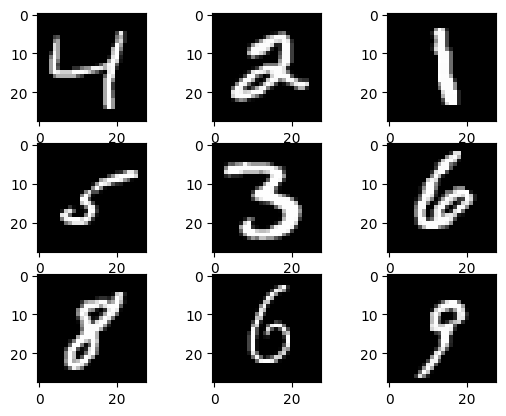

In [29]:
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

## Archive Model Versions

This step is needed to pass the next validation marks. All existing model versions are set to ARCHIVED so that the following asserts can validate
the exact number of models and versions.

In [31]:
archiveAllModelVersions()

StoreException: Context type kf.RegisteredModel does not exist

## Train simple neural network

Let's train a simple neural network.

In [32]:
model, model_name = simpleNN()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 104938 (409.91 KB)
Trainable params: 104938 (409.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
history = model.fit(X_train,y_train,epochs=10,validation_split=0.2)

Epoch 1/10
1400/1400 [==============================] - 7s 5ms/step - loss: 0.2810 - accuracy: 0.9184 - val_loss: 0.1669 - val_accuracy: 0.9509
Epoch 2/10
1400/1400 [==============================] - 6s 5ms/step - loss: 0.1185 - accuracy: 0.9642 - val_loss: 0.1247 - val_accuracy: 0.9625
Epoch 3/10
1400/1400 [==============================] - 6s 5ms/step - loss: 0.0804 - accuracy: 0.9751 - val_loss: 0.1184 - val_accuracy: 0.9626
Epoch 4/10
1400/1400 [==============================] - 7s 5ms/step - loss: 0.0611 - accuracy: 0.9811 - val_loss: 0.1084 - val_accuracy: 0.9683
Epoch 5/10
1400/1400 [==============================] - 7s 5ms/step - loss: 0.0467 - accuracy: 0.9856 - val_loss: 0.1295 - val_accuracy: 0.9645
Epoch 6/10
1400/1400 [==============================] - 6s 5ms/step - loss: 0.0389 - accuracy: 0.9878 - val_loss: 0.1247 - val_accuracy: 0.9654
Epoch 7/10
1400/1400 [==============================] - 6s 5ms/step - loss: 0.0307 - accuracy: 0.9906 - val_loss: 0.1074 - val_accuracy:

Evaluate model accuracy using test data

In [34]:
evaluateModelAccuracy(model, model_name)

438/438 [==============================] - 1s 2ms/step
Prediction accuracy for model `simple_NN` is: 97.63%


### Evaluate the trained model

1/1 [==============================] - 0s 14ms/step
prediction for sample 1 is:  0
**Note**: the calculated prediction 0 must match the number plotted below. If not, the test failed


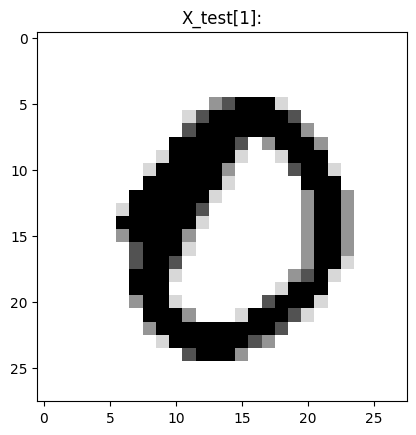

In [35]:
testModelForSample(model, 1)

### Save the model as ONNX file

In [36]:
file_name = saveModel(model, model_name)

Saved as simple_NN.onnx


2024-04-19 15:05:57.458158: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-04-19 15:05:57.458292: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-04-19 15:05:57.488041: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-04-19 15:05:57.488168: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session


### Test the saved model

['dense_2']
**Note**: the calculated prediction 6 must match the number plotted below. If not, the test failed


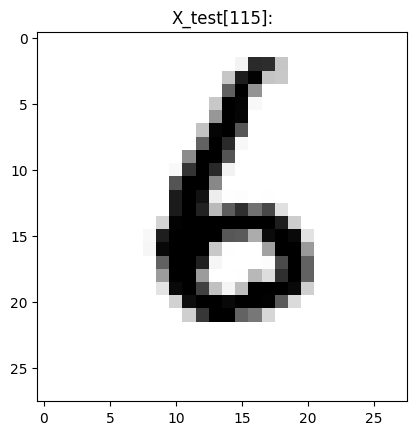

In [37]:
testModelFromFileForSample(file_name, 115)

### Store the model to S3 compatible bucket

In [38]:
registeredmodel_name, version_name, odh_secret_name, in_bucket_path, s3_uri = storeTrainedModel(model, model_name, file_name)

Will be using: mnist:v.simple_NN.20240419150600 in the remainder of this task
Objects in the feast bucket:
v.simple_NN.20240419150600/simple_NN.onnx


In [39]:
registeredmodel_name, version_name, odh_secret_name, in_bucket_path, s3_uri

('mnist',
 'v.simple_NN.20240419150600',
 'aws-connection-feast',
 'v.simple_NN.20240419150600',
 's3://feast/v.simple_NN.20240419150600/simple_NN.onnx?endpoint=http://minio-service.feast.svc.cluster.local:9000&defaultRegion=default')

### Register with Model Registry

In [40]:
registerToModelRegistry(
    registeredmodel_name, version_name, odh_secret_name, in_bucket_path, s3_uri
)

RegisteredModel:
RegisteredModel(id='1', description='', external_id='', create_time_since_epoch=1713539173108, last_update_time_since_epoch=1713539173108, state=<ContextState.LIVE: 'LIVE'>, name='mnist')
ModelVersion:
ModelVersion(name='v.simple_NN.20240419150600', id='2', description='demo20231121 e2e MNIST', external_id='', create_time_since_epoch=1713539173809, last_update_time_since_epoch=1713539173809, state=<ContextState.LIVE: 'LIVE'>, model_name='mnist', version='v.simple_NN.20240419150600', author='feast-dev@redhat.com', metadata={'AWS_DEFAULT_REGION': 'default', 'AWS_S3_BUCKET': 'feast', 'AWS_S3_ENDPOINT': 'http://minio-service.feast.svc.cluster.local:9000'}, artifacts=NOTHING, _registered_model_id=NOTHING)
ModelArtifact:
ModelArtifact(id='1', description='', external_id='', create_time_since_epoch=1713539174615, last_update_time_since_epoch=1713539174615, name='mnist', uri='s3://feast/v.simple_NN.20240419150600/simple_NN.onnx?endpoint=http://minio-service.feast.svc.cluster.l

## Train a convoluted neural network

Let's train a an alternative, a convoluted neural network:

In [41]:
model, model_name = convolutedNN()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                346176    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                      

In [42]:
history = model.fit(X_train,y_train,epochs=3)

Epoch 1/3
1750/1750 [==============================] - 36s 20ms/step - loss: 0.2758 - accuracy: 0.9181
Epoch 2/3
1750/1750 [==============================] - 36s 20ms/step - loss: 0.1197 - accuracy: 0.9634
Epoch 3/3
1750/1750 [==============================] - 37s 21ms/step - loss: 0.0884 - accuracy: 0.9728


In [43]:
evaluateModelAccuracy(model, model_name)

438/438 [==============================] - 3s 6ms/step
Prediction accuracy for model `convolutedNN` is: 98.06%


### Evaluate the trained model

1/1 [==============================] - 0s 15ms/step
prediction for sample 19 is:  8
**Note**: the calculated prediction 8 must match the number plotted below. If not, the test failed


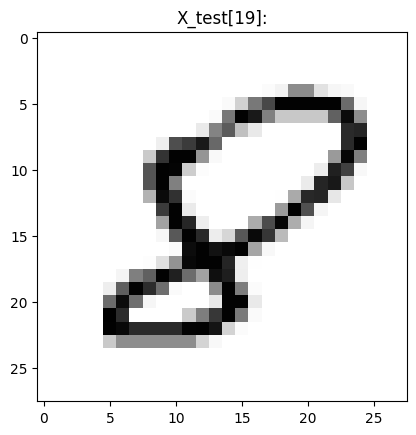

In [44]:
testModelForSample(model, 19)

### Save the model as ONNX file

In [45]:
file_name = saveModel(model, model_name)

Saved as convolutedNN.onnx


2024-04-19 15:08:25.184667: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-04-19 15:08:25.184802: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-04-19 15:08:25.223697: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-04-19 15:08:25.223810: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session


['dense_4']
**Note**: the calculated prediction 0 must match the number plotted below. If not, the test failed


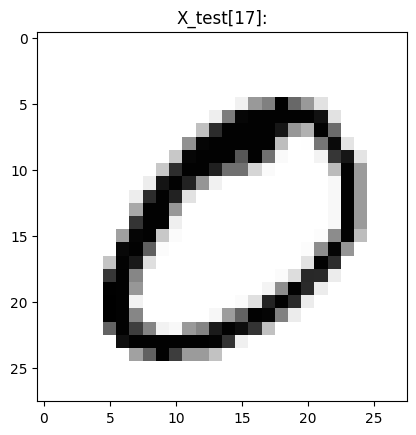

In [46]:
testModelFromFileForSample(file_name, 17)

In [47]:
registeredmodel_name, version_name, odh_secret_name, in_bucket_path, s3_uri = storeTrainedModel(model, model_name, file_name)

Will be using: mnist:v.convolutedNN.20240419150826 in the remainder of this task
Objects in the feast bucket:
v.convolutedNN.20240419150826/convolutedNN.onnx
v.simple_NN.20240419150600/simple_NN.onnx


In [48]:
registeredmodel_name, version_name, odh_secret_name, in_bucket_path, s3_uri

('mnist',
 'v.convolutedNN.20240419150826',
 'aws-connection-feast',
 'v.convolutedNN.20240419150826',
 's3://feast/v.convolutedNN.20240419150826/convolutedNN.onnx?endpoint=http://minio-service.feast.svc.cluster.local:9000&defaultRegion=default')

In [49]:
registry = registerToModelRegistry(
    registeredmodel_name, version_name + "1", odh_secret_name, in_bucket_path, s3_uri
)

RegisteredModel:
RegisteredModel(id='1', description='', external_id='', create_time_since_epoch=1713539173108, last_update_time_since_epoch=1713539173108, state=<ContextState.LIVE: 'LIVE'>, name='mnist')
ModelVersion:
ModelVersion(name='v.convolutedNN.202404191508261', id='3', description='demo20231121 e2e MNIST', external_id='', create_time_since_epoch=1713539308009, last_update_time_since_epoch=1713539308009, state=<ContextState.LIVE: 'LIVE'>, model_name='mnist', version='v.convolutedNN.202404191508261', author='feast-dev@redhat.com', metadata={'AWS_DEFAULT_REGION': 'default', 'AWS_S3_BUCKET': 'feast', 'AWS_S3_ENDPOINT': 'http://minio-service.feast.svc.cluster.local:9000'}, artifacts=NOTHING, _registered_model_id=NOTHING)
ModelArtifact:
ModelArtifact(id='2', description='', external_id='', create_time_since_epoch=1713539308624, last_update_time_since_epoch=1713539308624, name='mnist', uri='s3://feast/v.convolutedNN.20240419150826/convolutedNN.onnx?endpoint=http://minio-service.feast

## Inspect Model Registry

In [68]:
models = registry._api.get_registered_models()
assert len(models)==1, f"Found {len(models)} instead of just 1"

In [69]:
models = registry._api.get_registered_models()
for model in models:
    print(f"Model {model.name}: {model}")
    print("="*30)
    live_model_versions = [m for m in registry._api.get_model_versions(model.id) if m.state!=ContextState.ARCHIVED]
    for model_version in live_model_versions:
        print(f"Version {model_version.name}: {model_version}")
        print("="*30)
        for model_artifact in registry._api.get_model_artifacts(model_version.id):
            print(f"Artifact {model_artifact.name}: {model_artifact}")
            print("="*30)

Model mnist: RegisteredModel(id='1', description='', external_id='', create_time_since_epoch=1713539173108, last_update_time_since_epoch=1713539173108, state=<ContextState.LIVE: 'LIVE'>, name='mnist')
Version v.simple_NN.20240419150600: ModelVersion(name='v.simple_NN.20240419150600', id='2', description='demo20231121 e2e MNIST', external_id='', create_time_since_epoch=1713539173809, last_update_time_since_epoch=1713539173809, state=<ContextState.LIVE: 'LIVE'>, model_name='mnist', version='v.simple_NN.20240419150600', author='feast-dev@redhat.com', metadata={'AWS_DEFAULT_REGION': 'default', 'AWS_S3_BUCKET': 'feast', 'AWS_S3_ENDPOINT': 'http://minio-service.feast.svc.cluster.local:9000'}, artifacts=NOTHING, _registered_model_id=NOTHING)
Artifact mnist: ModelArtifact(id='1', description='', external_id='', create_time_since_epoch=1713539174615, last_update_time_since_epoch=1713539174615, name='mnist', uri='s3://feast/v.simple_NN.20240419150600/simple_NN.onnx?endpoint=http://minio-service.